# TGIS 2024

## 1.Obtaining GeoNN_best from Group I of experiments

In [1]:
#Check the Python version
!python --version

Python 3.10.12


In [ ]:
# Import all packages needed

%tensorflow_version 2.x

import pandas as pd
from pandas import DataFrame
import numpy as np
from numpy.random import Generator, PCG64
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.layers import Dense
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from sklearn.model_selection import train_test_split
import scipy.stats as st
import random
import os

In [3]:
# Configuration Set

# 1. Set the path to the dataset in the GitHub repository
PATH_DATA = "https://raw.githubusercontent.com/jaqueline-soares/TGIS2024/main/data/data_prev120min.csv"

# 2. Set the noise distribution. Options: 'UNIFORM' or 'NORMAL'.
DISTRIBUTION = 'UNIFORM'
#DISTRIBUTION = 'NORMAL'

In [4]:
# This function resets the seeds to guarantee the reproducibility of the experiments
def reset_seed(seed_value):

  # Set the `PYTHONHASHSEED` environment variable at a fixed value
  os.environ['PYTHONHASHSEED']=str(seed_value)

  # Set the `python` built-in pseudo-random generator at a fixed value
  random.seed(seed_value)

  # Set the `numpy` pseudo-random generator at a fixed value
  np.random.seed(seed_value)
  np.random.RandomState(seed_value)

  # Set the `tensorflow` pseudo-random generator at a fixed value
  tf.random.set_seed(seed_value)
  # for later versions:
  tf.compat.v1.set_random_seed(seed_value)

  # Configure a new global `tensorflow` session
  # session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  # sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
  # K.set_session(sess)
  # for later versions:
  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
  tf.compat.v1.keras.backend.set_session(sess)

In [5]:
# This function returns a truncated normal distribution
def get_truncated_normal(mean, sd, low, up, size):
    return st.truncnorm(
        (low - mean) / sd, (up - mean) / sd, loc=mean, scale=sd).rvs(size=size)

In [6]:
# Other configurations

# Set the `tensorflow` pseudo-random generator at a fixed value
SEED = 0
# Set the best seed for 120-minute predictions (Group I of experiments)
SEED_BEST = 97848
# Set the number of perturbations per input data
N_PERTURBATIONS = 10_000
# Set the possible additive noise rates
NOISE_ARRAY = np.linspace(-0.15, 0.15, num=121)

# Distribution configuration
if DISTRIBUTION == 'UNIFORM':
  GENERATOR_NOISE = Generator(PCG64(SEED))
  RANDOM_INDEX_NOISE = GENERATOR_NOISE.integers(low=0, high=len(NOISE_ARRAY), size=N_PERTURBATIONS)
elif DISTRIBUTION == 'NORMAL':
  reset_seed(SEED)
  RANDOM_INDEX_NOISE = get_truncated_normal(mean=60, sd=20, low=0, up=len(NOISE_ARRAY)-1, size=N_PERTURBATIONS)
  RANDOM_INDEX_NOISE = RANDOM_INDEX_NOISE.round().astype(int)

In [7]:
# This function calculates the Nash–Sutcliffe efficiency coefficient for the predicted values "y_pred" relative to the "y_true".
def nse(y_true, y_pred):
	return 1 - (K.sum((y_true - y_pred)**2)/
                         K.sum((y_true - K.mean(y_true))**2))

# This function calculates the RMSE between the predicted values "y_pred" and the observed ones "y_true".
def rmse(y_true, y_pred):
	return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [8]:
# This function returns the x values normalized
def norm(x, min, max):
    if (max - min) != 0:
        return (x - min) / (max - min)
    else:
        return np.nan

# This function returns the train_input, test_input, and val_input values normalized
def normalize_data(data, train_input, test_input, val_input):

  # Create empty datasets to store normalized data
  normed_train_data = DataFrame(columns=columns)
  normed_test_data = DataFrame(columns=columns)
  normed_val_data = DataFrame(columns=columns)

  # For each column
  for var_col in columns:
    MIN = data[var_col].min()
    MAX = data[var_col].max()
    normed_train_data[var_col] = norm(train_input[var_col], MIN, MAX)
    normed_test_data[var_col] = norm(test_input[var_col], MIN, MAX)
    normed_val_data[var_col] = norm(val_input[var_col], MIN, MAX)

  return normed_train_data, normed_test_data, normed_val_data

In [9]:
# This function loads the dataset from the repository
def read_data(path):

  data = pd.read_csv(path)

  data['datahora'] = pd.to_datetime(data['datahora'])
  data = data.set_index('datahora')
  data = data[183:]
  columns = []
  for column in data.columns:
    if 'acum12h' in column:
     columns.append(column)

  data.describe()
  return data, columns

In [10]:
class GetWeights(Callback):

    # Keras callback which collects values of weights and biases at each epoch
    def __init__(self):
        super(GetWeights, self).__init__()
        self.weight_dict = {}

    # This function runs at the end of each epoch
    def on_epoch_end(self, epoch, logs=None):

        # loop over each layer and get weights and biases
        for layer_i in range(len(self.model.layers)):
            w = self.model.layers[layer_i].get_weights()[0]
            b = self.model.layers[layer_i].get_weights()[1]

            # save all weights and biases inside a dictionary
            if epoch == 0:
                # create arrays to hold weights and biases
                self.weight_dict['w_'+str(layer_i+1)] = w
                self.weight_dict['b_'+str(layer_i+1)] = b
            else:
                # append new weights to previously-created weights arrays
                self.weight_dict['w_'+str(layer_i+1)] = np.dstack(
                    (self.weight_dict['w_'+str(layer_i+1)], w))
                self.weight_dict['b_'+str(layer_i+1)] = np.dstack(
                    (self.weight_dict['b_'+str(layer_i+1)], b))

In [11]:
# This function splits arrays or matrices into train and test subsets
def shuffle_train_test_split(data, columns, seed):

  X_train, X_test, y_train, y_test = train_test_split(data[columns], data[['out']], test_size=0.1, random_state=seed)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1111, random_state=seed)

  train_input = X_train[columns]
  train_targets = y_train['out']

  test_input = X_test[columns]
  test_targets = y_test['out']

  val_input = X_val[columns]
  val_targets = y_val['out']

  # reindex the datasets
  train_input.reset_index(inplace=True, drop=True)
  train_targets.reset_index(inplace=True, drop=True)

  test_input.reset_index(inplace=True, drop=True)
  test_targets.reset_index(inplace=True, drop=True)

  val_input.reset_index(inplace=True, drop=True)
  val_targets.reset_index(inplace=True, drop=True)

  return train_input, train_targets, test_input, test_targets, val_input, val_targets

In [12]:
# This function defines the neural network architecture
def model_creation(normed_train_data):

  input_dim = normed_train_data.shape[1]
  output_dim = 1

  model = Sequential()
  model.add(Dense(120,input_shape=(input_dim,),activation=tf.keras.activations.relu))
  model.add(Dense(50, activation=tf.keras.activations.relu))
  model.add(Dense(10, activation=tf.keras.activations.relu))
  model.add(Dense(output_dim, activation='linear' ))

  return model

# This function configures the model for training
def model_compile(model):

  opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
  model.compile(optimizer = opt, loss='mse', metrics=[rmse, nse])
  model.summary()
  checkpointer = ModelCheckpoint(filepath='checkpoint_model.hdf5', verbose=0, save_best_only=True)

  return model

# This function trains the model for a fixed number of epochs (dataset iterations)
def model_training_validation(model, normed_train_data, train_targets, normed_val_data, val_targets):

  gw = GetWeights()
  es_callback = EarlyStopping(monitor='loss', patience=12)
  model.fit(normed_train_data, train_targets, epochs=3000, batch_size=1024,
                      validation_data=(normed_val_data, val_targets),
                      callbacks=[es_callback], verbose=0)

  return model

# This function returns the loss value & metrics values for the model in test mode
def model_tests(model, normed_test_data, test_targets):

  loss, rmse_val, nse_val = model.evaluate(normed_test_data, test_targets, verbose=0, batch_size=1024)
  return loss, rmse_val, nse_val

In [13]:
# This function constructs and returns a DataFrame from a dictionary with the metrics information
def get_df_metrics(seed_array, rmse_array, nse_array):

  dict = {
      'seed': seed_array,
      'rmse': rmse_array,
      'nse': nse_array
      }
  df = DataFrame(data=dict)

  return df

In [14]:
# Main flow

# Load dataset from PATH_DATA
data, columns = read_data(PATH_DATA)

# Initialize arrays of metrics
rmse_array = []
nse_array = []

# Clear clutter from previous session graphs
K.clear_session()
reset_seed(SEED)

# Generate the GeoNN_best from SEED_BEST of Group I-experiments
print("\n****************************Seed {}****************************".format(SEED_BEST))
train_input, train_targets, test_input, test_targets, val_input, val_targets = shuffle_train_test_split(data, columns, SEED_BEST)
normed_train_data, normed_test_data, normed_val_data = normalize_data(data, train_input, test_input, val_input)
model = model_creation(normed_train_data)
model = model_compile(model)
model = model_training_validation(model, normed_train_data, train_targets, normed_val_data, val_targets)
loss, rmse_val, nse_val = model_tests(model, normed_test_data, test_targets)
rmse_array.append(rmse_val)
nse_array.append(nse_val)


****************************Seed 97848****************************
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 120)               45480     
                                                                 
 dense_1 (Dense)             (None, 50)                6050      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 52051 (203.32 KB)
Trainable params: 52051 (203.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# Clear clutter from previous session graphs
K.clear_session()
reset_seed(SEED)

In [16]:
df = get_df_metrics([SEED_BEST], rmse_array, nse_array)
df.head()

,seed,rmse,nse
0,97848,0.030929,0.90288


## 2.Group II of experiments

In [17]:
print('Index of the highest river level in the test dataset: ', test_targets.idxmax())
print('Highest river level in the test dataset: ', test_targets.loc[test_targets.idxmax()])

Index of the highest river level in the test dataset:  1278
Highest river level in the test dataset:  3.48


In [ ]:
# 100-instant interval from index 1200 to 1300. This specific time interval was selected since it presents the higher observed outlet river level in the test dataset.
df_test = pd.concat([normed_test_data.iloc[1200:1300], test_targets.iloc[1200:1300]], axis=1)
df_test.reset_index(inplace=True)

In [19]:
# Colors used in the graphs
COLOR_1 = 'tab:blue'
# Font size  used in the graphs
FONTSIZE_LARGE = 24

In [20]:
# This function plots a histogram from data
def plot_histogram(data, axes_labels, filename, bins=15):

  fig, axs = plt.subplots(figsize=(11,8))

  n, bins, patches = axs.hist(data, bins = bins, color=COLOR_1, alpha=0.6, edgecolor="black")

  axs.set_xlabel(axes_labels[0], fontsize=FONTSIZE_LARGE)
  axs.set_ylabel(axes_labels[1], fontsize=FONTSIZE_LARGE)
  plt.xticks(fontsize=FONTSIZE_LARGE)
  plt.yticks(fontsize=FONTSIZE_LARGE)
  axs.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y/100}'))

  plt.show()

In [21]:
PERTURBATIONS=[]
for index in RANDOM_INDEX_NOISE:
  # Generate the array with additive noise rates from -15 to +15
  PERTURBATIONS.append(NOISE_ARRAY[index]*100)

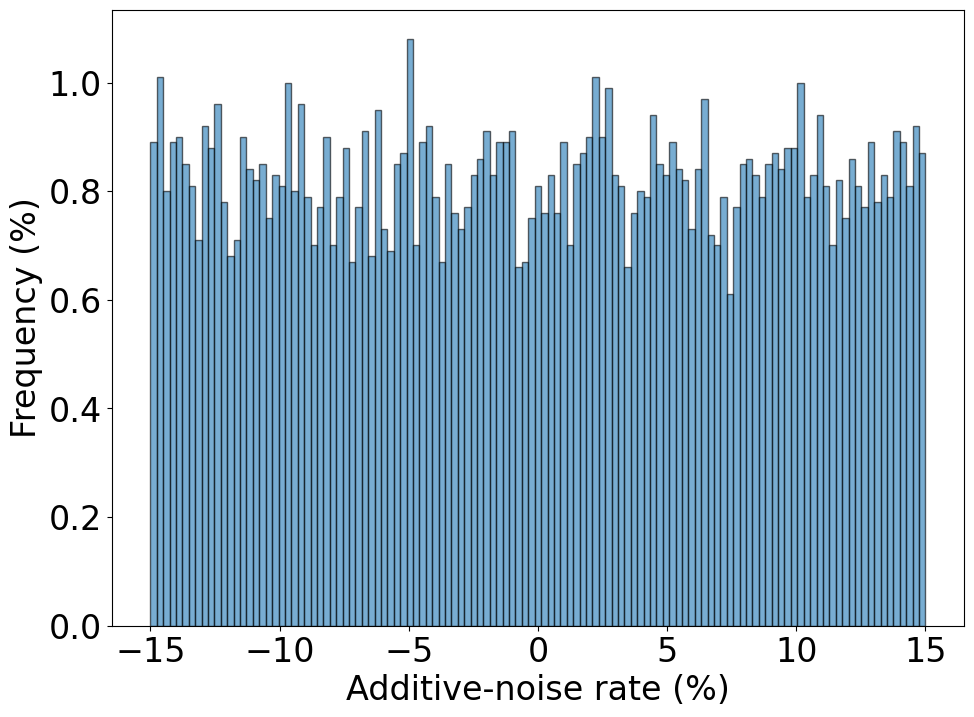

In [22]:
plot_histogram(PERTURBATIONS, ['Additive-noise rate (%)', 'Frequency (%)'], filename="hist", bins=len(NOISE_ARRAY))

In [23]:
# Metrics for the entire dataset

# Calculate the standard deviation of the river level values
THRESHOLD_SIGMA_DS = np.std(data['out'])
print('Standard deviation of the river level values: ', THRESHOLD_SIGMA_DS)

# Calculate the average of the river level values
THRESHOLD_MEAN_DS = np.mean(data['out'])
print('\nAverage of the river level values: ', THRESHOLD_MEAN_DS)

# Calculate the flood threshold, corresponding to the sum of the mean of the river level values plus two times the standard deviation of this distribution
THRESHOLD_FLOOD_DS = THRESHOLD_MEAN_DS + 2 * THRESHOLD_SIGMA_DS
print('\nFlood Threshold (mean + 2 * standard deviation): ', THRESHOLD_FLOOD_DS)

Standard deviation of the river level values:  0.16148699976331618

Average of the river level values:  1.6287416949998441

Flood Threshold (mean + 2 * standard deviation):  1.9517156945264764


In [24]:
# This function calculates all possible perturbations to the observed input data 'data' according to the 121 discrete noise levels
def get_perturbation_all_options(data):
  input_perturbation_all_options = []
  output_perturbation_all_options = []

  for i in range(len(NOISE_ARRAY)):
    input_perturbation = (data * (1 + NOISE_ARRAY[i])).values.tolist()
    input_perturbation_all_options.append(input_perturbation)
    output_perturbation_all_options.append(model.predict([input_perturbation], verbose = 0)[0][0])

  return input_perturbation_all_options, output_perturbation_all_options

In [25]:
# This function generates structures to store 'N_PERTURBATIONS' input perturbations and the corresponding model predictions for each observed input data in 'df'
def get_input_array(df):
  input_real_array = []
  output_prediction_array = []
  noise = []
  input_perturbation_array = []
  output_perturbation_array = []

  for index, row in df.iterrows():
    input_perturbation_all_options, output_perturbation_all_options = get_perturbation_all_options(row[columns])
    group_noise_array = []
    group_input_array = []
    group_output_array = []

    for i in range(N_PERTURBATIONS):
      random_index = RANDOM_INDEX_NOISE[i]
      group_noise_array.append(NOISE_ARRAY[random_index])
      group_input_array.append(input_perturbation_all_options[random_index])
      group_output_array.append(output_perturbation_all_options[random_index])

    input_real_array.append(row[columns].values.tolist())
    output_prediction_array.append(model.predict([row[columns].values.tolist()], verbose = 0)[0][0])
    noise.append(group_noise_array)
    input_perturbation_array.append(group_input_array)
    output_perturbation_array.append(group_output_array)

  return input_real_array, output_prediction_array, noise, input_perturbation_array, output_perturbation_array

In [26]:
input_real_array, output_prediction_array, perturbation_array, input_perturbation_array, output_perturbation_array = get_input_array(df_test)

In [27]:
# This function constructs and returns a DataFrame from a dictionary with the Group II-experiments information
def get_df_variations(df_test, input_real_array, output_prediction_array, perturbation_array, input_perturbation_array, output_perturbation_array, threshold):

  alert = []
  mean_output_perturbation = []
  median_output_perturbation = []
  min_output_perturbation = []
  max_output_perturbation = []
  std_output_perturbation = []
  for output_perturbation in output_perturbation_array:
    alert.append(np.sum(level > threshold for level in output_perturbation) / np.size(output_perturbation))
    mean_output_perturbation.append(np.mean(output_perturbation))
    median_output_perturbation.append(np.median(output_perturbation))
    min_output_perturbation.append(np.min(output_perturbation))
    max_output_perturbation.append(np.max(output_perturbation))
    std_output_perturbation.append(np.std(output_perturbation))

  dict = {
      'input_real': input_real_array,
      'perturbation': perturbation_array,
      'input_perturbation': input_perturbation_array,
      'output_real': df_test['out'],
      'output_prediction': output_prediction_array,
      'output_perturbation': output_perturbation_array,
      'alert': alert,
      'std_output_perturbation': std_output_perturbation,
      'mean_output_perturbation': mean_output_perturbation,
      'median_output_perturbation': median_output_perturbation,
      'min_output_perturbation': min_output_perturbation,
      'max_output_perturbation': max_output_perturbation
      }
  df_variations = DataFrame(data=dict)

  return df_variations

In [ ]:
df_variations = get_df_variations(df_test, input_real_array, output_prediction_array, perturbation_array, input_perturbation_array, output_perturbation_array, THRESHOLD_FLOOD_DS)

In [29]:
# Select the time instants with a non-zero probability of flooding
df_alerts = df_variations[df_variations["alert"] > 0]
# Select specific columns
df_alerts[['output_real', 'median_output_perturbation', 'alert']].head(20)

,output_real,median_output_perturbation,alert
14,2.87,3.043872,1.0000
48,2.23,2.261650,1.0000
49,2.32,2.380873,1.0000
64,1.94,1.999654,0.8061
73,2.14,2.235871,1.0000
78,3.48,3.559029,1.0000
89,2.13,2.179374,1.0000
